In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchdiffeq import odeint
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch.utils.data import Dataset, DataLoader

import numpy as np

import random

import warnings
import datetime

from copy import deepcopy

import pickle

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
class LotkaVolterraDataset(Dataset):
    """
    Deterministic Lotka-Voleterra synthetic dataset.
    
    Produces data for the system of predator vs prey
    
    Prey population is u, predator population is v, the dynamics
    are given by:
    
    u' = au - buv
    v' = duv - cv
    
    There is also a conserved quantity V (this is the privileged information):
    
    V = du - cln(u) + bv - aln(v)
    
    Parameters
        n       : int, number of samples
        dt      : float, time step
        freq    : int, how frequently to sample (multiple of dt)
        samples : int, how many samples to take (multiples of freq)
                  (an extra sample is include for t=0)
    (possible) sampling parameters
        u1,v1   : initial populations
        a       : reproduction rate
        b       : predation rate
        c       : death rate
        d       : predator reproduction rate
    If a float is provided for a sampling parameter, it is fixed at that value;
    if a list is provided, it will be uniformly sampled from the range.

    The time step, freq and samples default to
        dt      : 0.01
        freq    : 10
        samples : 10
    n defaults to 1.
    
    The 'inputs' are the sampled parameters, i.e. if only the initial
    positions are left unspecified and the 'outputs' are the positions
    over time (x1(t),x2(t)).
    
    Output times are normalised to run 0 to 1, such that the first sample
    is always at time = 0 and the final is always at time = 1.
    """
    
    def __init__(self, config, train=True, verbose=True):

        # from config
        #   base simulator setup
        self.dt = config['simulator']['dt']
        self.freq = config['simulator']['sampling_freq']
        self.samples = config['simulator']['samples']
        #   system parameter dictionaries
        self.fixed = config['fixed']
        if train:
            self.varying = config['varying']
            self.n = config['train_examples']
        else:
            self.varying = config['eval_varying']
            self.n = config['eval_examples']
        
        # + 1 for the extra sample at t = 0
        self.total_steps = self.freq*self.samples + 1
        # normalised times
        self.times = torch.arange(0,self.samples+1,1)/(1.*self.samples)
        
        if verbose:
            if train:
                print('Training data generation...')
            else:
                print('Evaluation data generation...')
            print('Fixed paramters', self.fixed)
            print('Varying parameters', self.varying)
        
        self.data = []
        # generate data
        for _ in range(self.n):
            description, conditions = self.description_and_conditions()
            output = self.single_run(conditions)
            self.data.append((description, output, self.times))
        
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return self.n
    
    def description_and_conditions(self):
        """
        Return a sample of initial conditions, with those specified at
        input being fixed and the unspecified being the description, too.
        """
        
        conditions = deepcopy(self.fixed)
        for key in self.varying:
            if key in conditions:
                warnings.warn('System parameter defined in both fixed and varying configs')
            low = min(self.varying[key])
            high = max(self.varying[key])
            conditions[key] = np.random.uniform(low,high)
        
        # the description is the varying part
        u1 = conditions['u1']
        v1 = conditions['v1']
        a = conditions['a']
        b = conditions['b']
        c = conditions['c']
        d = conditions['d']
        description = [d*u1 - c*np.log(u1) + b*v1 - a*np.log(v1)]
        
        return torch.FloatTensor(description), conditions
    
    def single_run(self, conditions):
        u = conditions['u1']
        v = conditions['v1']
        a = conditions['a']
        b = conditions['b']
        c = conditions['c']
        d = conditions['d']
        output = []
        for step in range(self.total_steps):
            if step % self.freq == 0:
                output.append([u,v])
            
            du = (a*u - b*u*v)*self.dt
            dv = (d*u*v - c*v)*self.dt
            
            u += du
            v += dv
    
        return torch.FloatTensor(output)

In [3]:
class obs_encoder(nn.Module):
    """
    Takes raw observations (x_i, t_i) and produces a representation r_i.
    """
    
    def __init__(self,config):
        super(obs_encoder, self).__init__()
        
        obs_dim = config['x_dim']
        h_dim = config['obs_enc_h_dim']
        r_dim = config['r_dim']
        
        layers = [
            nn.Linear(obs_dim+1,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,r_dim)
        ]
        
        self.layers = torch.nn.Sequential(*layers)
    
    def forward(self, observations, times):
        return self.layers(torch.cat([observations, times.unsqueeze(-1)],-1))

In [4]:
class pi_encoder(nn.Module):
    """
    Takes the privileged information signal and produces a representation r_p.
    """
    def __init__(self, config):
        super(pi_encoder, self).__init__()
        
        pi_dim = config['pi_dim']
        h_dim = config['pi_enc_h_dim']
        r_dim = config['pi_r_dim']
        
        layers = [
            nn.Linear(pi_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,r_dim)
        ]
        
        self.layers = torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [5]:
class r_aggregator(nn.Module):
    """
    Takes mixed representations from observations and privileged information and
    produces a single task representation.
    
    In evaluation mode privileged information should not be used and a warning will
    given if this is attempted.
    """
    def __init__(self, config):
        super(r_aggregator, self).__init__()
        
        obs_r_dim = config['r_dim']
        pi_r_dim = config['pi_r_dim']
        h_dim = config['agg_h_dim']
        
        self.aggregators = config['aggregators']
        
        for agg in self.aggregators:
            if agg not in ['mean','max','min','logsumexp']:
                raise ValueError(f'Aggregator {agg} is not supported.')
        
        # when using privileged information we combine the representations with a small ResNet
        layers = [
            nn.Linear(obs_r_dim*len(self.aggregators)+pi_r_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,obs_r_dim*len(self.aggregators))
        ]
        
        self.layers = torch.nn.Sequential(*layers)
        
    def aggregate(self, obs_r):
        # concatentate the aggregator outputs
        agg = []
        if 'max' in self.aggregators:
            agg.append(torch.max(obs_r,0).values)
        if 'min' in self.aggregators:
            agg.append(torch.min(obs_r,0).values)
        if 'logsumexp' in self.aggregators:
            agg.append(torch.logsumexp(obs_r,0))
        if 'mean' in self.aggregators:
            agg.append(torch.mean(obs_r,0))
        
        return torch.cat(agg, 0)
        
    def forward(self, r_i, r_p=None):
        if not self.training and r_p is not None:
            warnings.warn('Privileged information provided to the aggregator in evaluation mode.')
        
        # aggregate observations
        r_obs = self.aggregate(r_i)
        
        # if we have privileged information, use the resnet
        # r_obs' = r_obs + f(r_obs, r_p)
        if r_p is not None:
            r_obs = r_obs + self.layers(torch.cat([r_obs, r_p], -1))
        
        return r_obs

In [6]:
class r_to_z(nn.Module):
    """
    From task representation to global latent variable.
    """
    def __init__(self, config):
        super(r_to_z, self).__init__()
        
        aggregated_r_dim = config['r_dim'] * len(config['aggregators'])
        h_dim = config['r_to_z_h_dim']
        z_dim = config['z_dim']
        
        layers = [
            nn.Linear(aggregated_r_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU()
        ]
        
        self.layers = torch.nn.Sequential(*layers)
        
        self.h_to_mu = torch.nn.Linear(h_dim, z_dim)
        self.h_to_sigma = torch.nn.Linear(h_dim, z_dim)
        
    def forward(self, r):
        h = self.layers(r)
        mu = self.h_to_mu(h)
        sigma = 0.1 + 0.9*torch.sigmoid(self.h_to_sigma(h))
        
        return Normal(mu, sigma)

In [7]:
class z_to_L0(nn.Module):
    """
    Use a sample from the global latent variable to produce the initial L value.
    """
    def __init__(self,config):
        super(z_to_L0, self).__init__()
        
        L_dim = config['L_dim']
        z_dim = config['z_dim']
        h_dim = config['z_to_L_h_dim']
        
        layers = [
            nn.Linear(z_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,L_dim)
        ]
        
        self.layers = torch.nn.Sequential(*layers)
        
    def forward(self, z_sample):
        return self.layers(z_sample)

In [8]:
class conditional_ODE_func(nn.Module):
    """
    Conditional derivative function.
    
    Input is a concatentation of the ODE latent state and the global latent variable sample,
    and the time
        (L || z, t)
    Output is the derivative at that time
        (dL || dz)
    with dz set to 0.
    
    This is a 'hacky' way to condition the ODE without letting the sample varying.
    """
    
    def __init__(self,config):
        super(conditional_ODE_func, self).__init__()
        
        L_dim = config['L_dim']
        z_dim = config['z_dim']
        h_dim = config['ode_h_dim']
        
        layers = [
            torch.nn.Linear(L_dim+z_dim+1,h_dim),
            torch.nn.Softplus(),
            torch.nn.Linear(h_dim,h_dim),
            torch.nn.Softplus(),
            torch.nn.Linear(h_dim,L_dim)
        ]
        
        self.latent_func = torch.nn.Sequential(*layers)
        
        self.L_dim = L_dim
        
        self.nfe = 0
    
    def forward(self, t, L_z):
        self.nfe += 1
        z = L_z[self.L_dim:]
        L_z_t = torch.cat([L_z,t.unsqueeze(-1)])
        dL = self.latent_func(L_z_t)
        dz = torch.zeros_like(z)
        
        return torch.cat([dL,dz])

In [9]:
class decoder(nn.Module):
    """
    Produce an output from the ODE latent state and the global latent variable sample.
    """
    def __init__(self, config):
        super(decoder, self).__init__()
        
        L_dim = config['L_dim']
        z_dim = config['z_dim']
        h_dim = config['dec_h_dim']
        out_dim = config['x_dim']
        
        layers = [
            torch.nn.Linear(L_dim+z_dim,h_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(h_dim,h_dim),
            torch.nn.ReLU()
        ]
        
        self.shared_layers = torch.nn.Sequential(*layers)
        
        self.hidden_to_mu = torch.nn.Linear(h_dim, out_dim)
        self.hidden_to_sigma = torch.nn.Linear(h_dim, out_dim)
        
    def forward(self, L_z_t):
        
        hidden = self.shared_layers(L_z_t)
        mu = self.hidden_to_mu(hidden)
        sigma = 0.1 + 0.9*F.softplus(self.hidden_to_sigma(hidden))
        return Normal(mu, sigma)

In [10]:
class LUPI_NDP(nn.Module):
    
    def __init__(self, config):

        super(LUPI_NDP, self).__init__()
        
        self.observations_encoder = obs_encoder(config)
        self.privileged_info_encoder = pi_encoder(config)
        self.representation_aggregator = r_aggregator(config)
        self.representation_to_global_latent = r_to_z(config)
        self.global_latent_to_initial_value = z_to_L0(config)
        self.odefunc = conditional_ODE_func(config)
        self.decoder = decoder(config)
        
    def forward(self, observations, times, p_info, context_idx, target_idx):
        if self.training:
            # encode
            r_i = self.observations_encoder(observations, times)
            r_p = self.privileged_info_encoder(p_info)
            # aggregate
            r_C = self.representation_aggregator(r_i[context_idx],None)
            r_T = self.representation_aggregator(r_i[target_idx],r_p)
            # parametrise
            z_C = self.representation_to_global_latent(r_C)
            z_T = self.representation_to_global_latent(r_T)
            # sample (from target Z during training)
            z_ = z_T.rsample()
            # initialise and evolve
            L0 = self.global_latent_to_initial_value(z_)
            L_z = torch.cat([L0,z_])
            ################ this bit won't work with batching yet
            L_z_t = odeint(self.odefunc, L_z, times[target_idx])
            return z_C, z_T, self.decoder(L_z_t)
        
        else:
            # encode
            r_i = self.observations_encoder(observations[context_idx],
                                            times[context_idx])
            # aggregate
            r_C = self.representation_aggregator(r_i,None)
            # parametrise
            z_C = self.representation_to_global_latent(r_C)
            # sample (from context Z during eval.)
            z_ = z_C.rsample()
            # initialise and evolve
            L0 = self.global_latent_to_initial_value(z_)
            L_z = torch.cat([L0,z_])
            ################ this bit won't work with batching yet
            L_z_t = odeint(self.odefunc, L_z, times[target_idx].squeeze())
            return self.decoder(L_z_t)

In [11]:
class NDP(nn.Module):
    """
    No privileged information NDP model built to sub in directly for the LUPI
    model for the sake of experimental consistency. Primarily this means that
    the forward pass takes a 'p_info' argument despite not using it.
    """
    
    def __init__(self, config):

        super(NDP, self).__init__()
        
        self.observations_encoder = obs_encoder(config)
        self.representation_aggregator = r_aggregator(config)
        self.representation_to_global_latent = r_to_z(config)
        self.global_latent_to_initial_value = z_to_L0(config)
        self.odefunc = conditional_ODE_func(config)
        self.decoder = decoder(config)
        
    def forward(self, observations, times, p_info, context_idx, target_idx):
        if self.training:
            # encode
            r_i = self.observations_encoder(observations, times)
            # aggregate (no PI so both aggregate without it)
            r_C = self.representation_aggregator(r_i[context_idx],None)
            r_T = self.representation_aggregator(r_i[target_idx],None)
            # parametrise
            z_C = self.representation_to_global_latent(r_C)
            z_T = self.representation_to_global_latent(r_T)
            # sample (from target Z during training)
            z_ = z_T.rsample()
            # initialise and evolve
            L0 = self.global_latent_to_initial_value(z_)
            L_z = torch.cat([L0,z_])
            ################ this bit won't work with batching yet
            L_z_t = odeint(self.odefunc, L_z, times[target_idx])
            return z_C, z_T, self.decoder(L_z_t)
        
        else:
            # encode
            r_i = self.observations_encoder(observations[context_idx],
                                            times[context_idx])
            # aggregate
            r_C = self.representation_aggregator(r_i,None)
            # parametrise
            z_C = self.representation_to_global_latent(r_C)
            # sample (from context Z during eval.)
            z_ = z_C.rsample()
            # initialise and evolve
            L0 = self.global_latent_to_initial_value(z_)
            L_z = torch.cat([L0,z_])
            ################ this bit won't work with batching yet
            L_z_t = odeint(self.odefunc, L_z, times[target_idx].squeeze())
            return self.decoder(L_z_t)

In [12]:
lupi_save = 'lupi-lv-2021-02-13-2217'
nopi_save = 'nopi-lv-2021-02-15-0018'

In [13]:
time_save = datetime.datetime.now()
time_save.strftime("%Y-%m-%d-%H%M")

'2021-02-19-1102'

In [14]:
lupi_config = pickle.load(open('./saves/'+lupi_save+'-config.p', 'rb'))
nopi_config = pickle.load(open('./saves/'+nopi_save+'-config.p', 'rb'))
lupi_model = torch.load('./saves/'+lupi_save)
nopi_model = torch.load('./saves/'+nopi_save)
context_range = range(min(lupi_config['context_range']),max(lupi_config['context_range']))
target_range = range(min(lupi_config['target_range']),max(lupi_config['target_range']))

In [15]:
evaluation_config = {
    # data stuff
    'eval_examples' : 500,
    'simulator' : {
        'dt' : 0.01,
        'sampling_freq' : 20,
        'samples' : 50
    },
    'fixed' : {
        'a' : 2/3,
        'b' : 4/3,
        'c' : 1,
        'd' : 1,
    },
    'varying' : {
        'u1' : [0.2, 1.],
        'v1' : [0.1, 0.5]
    },
    'eval_varying' : {
        'u1' : [0.8, 1.2],
        'v1' : [0.3, 0.6]
    },
}

Evaluation data generation...
Fixed paramters {'a': 0.6666666666666666, 'b': 1.3333333333333333, 'c': 1, 'd': 1}
Varying parameters {'u1': [0.8, 1.2], 'v1': [0.3, 0.6]}


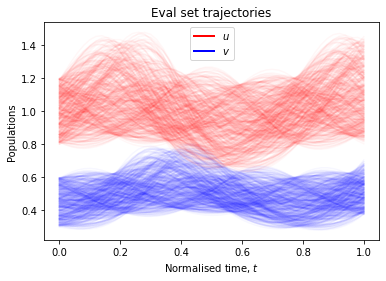

In [16]:
# dataset
eval_set = LotkaVolterraDataset(evaluation_config, train=False)
eval_examples = len(eval_set)

# loader
eval_loader = DataLoader(eval_set, batch_size=1)

# sanity plot
for inputs, labels, times in eval_loader:
    plt.plot(times[0], labels[0,:,0], alpha=0.03, c='r')
    plt.plot(times[0], labels[0,:,1], alpha=0.03, c='b')
plt.title('Eval set trajectories')
custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2)]
plt.legend(custom_lines, ['$u$', '$v$'])
plt.xlabel('Normalised time, $t$')
plt.ylabel('Populations')
plt.show()

### Paired evaluation

In [17]:
z_samples = 32

with torch.no_grad():
    
    # for mse
    lupi_train_errors = []
    lupi_eval_errors = []
    nopi_train_errors = []
    nopi_eval_errors = []
    
    # for calibration
    lupi_train_obs_confidences = []
    lupi_eval_obs_confidences = []
    nopi_train_obs_confidences = []
    nopi_eval_obs_confidences = []
    
    # for sharpness
    lupi_train_sharpness = []
    lupi_eval_sharpness = []
    nopi_train_sharpness = []
    nopi_eval_sharpness = []
    
    for i, batch in enumerate(eval_loader):
        # get example
        pi, x, times = batch
        
        lupi_train_preds = []
        lupi_eval_preds = []
        nopi_train_preds = []
        nopi_eval_preds = []

        context_range = range(5,10)
        target_range = range(15,51)

        context_size = random.sample(context_range,1)[0] # some number in the range 5 to 9
        target_size = random.sample(target_range,1)[0] # some number in the range 15 to 50
        target_idx = list(range(evaluation_config['simulator']['samples'])) # a set of indices
        context_idx = random.sample(target_idx, context_size) # a subset of the target indices
        target_idx.sort()
        context_idx.sort()
        target_idx = torch.LongTensor(target_idx)
        context_idx = torch.LongTensor(context_idx)
        
        for _ in range(z_samples):
            # lupi
            lupi_model.train()
            _,_,lupi_train_pr = lupi_model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
            lupi_train_preds.append(lupi_train_pr.loc.detach())
            lupi_model.eval()
            lupi_eval_pr = lupi_model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
            lupi_eval_preds.append(lupi_eval_pr.loc.detach())
            
            # nopi
            nopi_model.train()
            _,_,nopi_train_pr = nopi_model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
            nopi_train_preds.append(nopi_train_pr.loc.detach())
            nopi_model.eval()
            nopi_eval_pr = nopi_model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
            nopi_eval_preds.append(nopi_eval_pr.loc.detach())
        # aggregate predictions
        lupi_train_mean = torch.stack(lupi_train_preds,0).mean(0)
        lupi_train_std = torch.stack(lupi_train_preds,0).std(0)
        lupi_eval_mean = torch.stack(lupi_eval_preds,0).mean(0)
        lupi_eval_std = torch.stack(lupi_eval_preds,0).std(0)
        nopi_train_mean = torch.stack(nopi_train_preds,0).mean(0)
        nopi_train_std = torch.stack(nopi_train_preds,0).std(0)
        nopi_eval_mean = torch.stack(nopi_eval_preds,0).mean(0)
        nopi_eval_std = torch.stack(nopi_eval_preds,0).std(0)
        
        # mse calculations
        lupi_train_errors.append(torch.mean((lupi_train_mean - x.squeeze(0)[:-1])**2).item())
        lupi_eval_errors.append(torch.mean((lupi_eval_mean - x.squeeze(0)[:-1])**2).item())
        nopi_train_errors.append(torch.mean((nopi_train_mean - x.squeeze(0)[:-1])**2).item())
        nopi_eval_errors.append(torch.mean((nopi_eval_mean - x.squeeze(0)[:-1])**2).item())
        
        # calibration
        lupi_train_obs_confidences.append(Normal(lupi_train_mean, lupi_train_std).cdf(x.squeeze(0)[:-1]))
        lupi_eval_obs_confidences.append(Normal(lupi_eval_mean, lupi_eval_std).cdf(x.squeeze(0)[:-1]))
        nopi_train_obs_confidences.append(Normal(nopi_train_mean, nopi_train_std).cdf(x.squeeze(0)[:-1]))
        nopi_eval_obs_confidences.append(Normal(nopi_eval_mean, nopi_eval_std).cdf(x.squeeze(0)[:-1]))
        
        # sharpness
        lupi_train_sharpness.append(torch.mean(lupi_train_std).item())
        lupi_eval_sharpness.append(torch.mean(lupi_eval_std).item())
        nopi_train_sharpness.append(torch.mean(nopi_train_std).item())
        nopi_eval_sharpness.append(torch.mean(nopi_eval_std).item())

#### Calculate MSE

In [18]:
# calculate MSE and standard error on the MSE
lupi_train_error_mean = np.mean(lupi_train_errors)
lupi_train_stderr_mean = np.std(lupi_train_errors)/len(eval_loader)**0.5
lupi_eval_error_mean = np.mean(lupi_eval_errors)
lupi_eval_stderr_mean = np.std(lupi_eval_errors)/len(eval_loader)**0.5
nopi_train_error_mean = np.mean(nopi_train_errors)
nopi_train_stderr_mean = np.std(nopi_train_errors)/len(eval_loader)**0.5
nopi_eval_error_mean = np.mean(nopi_eval_errors)
nopi_eval_stderr_mean = np.std(nopi_eval_errors)/len(eval_loader)**0.5

print('LUPI model train mode MSE :', '{:.5e}'.format(lupi_train_error_mean),
      '±', '{:.5e}'.format(lupi_train_stderr_mean))
print('LUPI model eval mode MSE  :', '{:.5e}'.format(lupi_eval_error_mean),
      '±', '{:.5e}'.format(lupi_eval_stderr_mean))
print('NoPI model train mode MSE :', '{:.5e}'.format(nopi_train_error_mean),
      '±', '{:.5e}'.format(nopi_train_stderr_mean))
print('NoPI model eval mode MSE  :', '{:.5e}'.format(nopi_eval_error_mean),
      '±','{:.5e}'.format( nopi_eval_stderr_mean))


LUPI model train mode MSE : 6.72578e-03 ± 3.57831e-04
LUPI model eval mode MSE  : 7.48038e-03 ± 3.97349e-04
NoPI model train mode MSE : 7.18151e-03 ± 3.92813e-04
NoPI model eval mode MSE  : 8.25739e-03 ± 4.48527e-04


#### Calculate sharpness and dispersion, and plot sharpness histogram

In [19]:
# calculate the shaprness and standard error on the sharpness
lupi_train_sharpness_mean = (np.mean(np.array(lupi_train_sharpness)**2))**0.5
lupi_eval_sharpness_mean = (np.mean(np.array(lupi_eval_sharpness)**2))**0.5
nopi_train_sharpness_mean = (np.mean(np.array(nopi_train_sharpness)**2))**0.5
nopi_eval_sharpness_mean = (np.mean(np.array(nopi_eval_sharpness)**2))**0.5

lupi_train_dispersion = np.std(lupi_train_sharpness)/np.mean(lupi_train_sharpness)
lupi_eval_dispersion = np.std(lupi_eval_sharpness)/np.mean(lupi_eval_sharpness)
nopi_train_dispersion = np.std(nopi_train_sharpness)/np.mean(nopi_train_sharpness)
nopi_eval_dispersion = np.std(nopi_eval_sharpness)/np.mean(nopi_eval_sharpness)

print('LUPI model train mode sharpness :', '{:.5e}'.format(lupi_train_sharpness_mean))
print('LUPI model eval mode sharpness  :', '{:.5e}'.format(lupi_eval_sharpness_mean))
print('NoPI model train mode sharpness :', '{:.5e}'.format(nopi_train_sharpness_mean))
print('NoPI model eval mode sharpness  :', '{:.5e}'.format(nopi_eval_sharpness_mean))

LUPI model train mode sharpness : 1.18418e-02
LUPI model eval mode sharpness  : 1.89865e-02
NoPI model train mode sharpness : 9.02711e-03
NoPI model eval mode sharpness  : 1.81901e-02


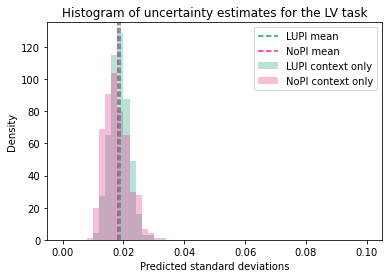

In [20]:
f = plt.figure()

plt.hist(lupi_eval_sharpness, bins=50, density=True, range=(0.,0.1), color='#1b9e77', alpha=0.3, label='LUPI context only')
plt.hist(nopi_eval_sharpness, bins=50, density=True, range=(0.,0.1), color='#e7298a', alpha=0.3, label='NoPI context only')

plt.axvline(x=lupi_eval_sharpness_mean, ls='--', color='#1b9e77', label='LUPI mean')
plt.axvline(x=nopi_eval_sharpness_mean, ls='--', color='#e7298a', label='NoPI mean')

plt.legend()
plt.title('Histogram of uncertainty estimates for the LV task')
plt.xlabel('Predicted standard deviations')
plt.ylabel('Density')

f.savefig('./figures/'+time_save.strftime("%Y-%m-%d-%H%M")+'lv_sharpness.pdf', bbox_inches='tight')

plt.show()

#### Calculate and plot calibration

In [21]:
lupi_train_cum  = []
lupi_eval_cum = []
nopi_train_cum = []
nopi_eval_cum = []

lupi_train_calibration_err = []
lupi_eval_calibration_err = []
nopi_train_calibration_err = []
nopi_eval_calibration_err = []

for lupi_tr, lupi_ev, nopi_tr, nopi_ev in zip(lupi_train_obs_confidences,
                                              lupi_eval_obs_confidences,
                                              nopi_train_obs_confidences,
                                              nopi_eval_obs_confidences):
    # to numpy
    lupi_tr_d, lupi_ev_d = lupi_tr.numpy(), lupi_ev.numpy()
    nopi_tr_d, nopi_ev_d = nopi_tr.numpy(), nopi_ev.numpy()
    # regular histograms
    lupi_tr_v, lupi_tr_b = np.histogram(lupi_tr_d, bins=50, range=(0.,1.))
    lupi_ev_v, lupi_ev_b = np.histogram(lupi_ev_d, bins=50, range=(0.,1.))
    nopi_tr_v, nopi_tr_b = np.histogram(nopi_tr_d, bins=50, range=(0.,1.))
    nopi_ev_v, nopi_ev_b = np.histogram(nopi_ev_d, bins=50, range=(0.,1.))
    
    # middle of bins
    base = (lupi_tr_b[:-1]+lupi_tr_b[1:])/2
    
    # cumulative histogram, normalised to run 0 to 1
    norm_lupi_tr_v = np.cumsum(lupi_tr_v)/lupi_tr_d.size
    norm_lupi_ev_v = np.cumsum(lupi_ev_v)/lupi_ev_d.size
    norm_nopi_tr_v = np.cumsum(nopi_tr_v)/nopi_tr_d.size
    norm_nopi_ev_v = np.cumsum(nopi_ev_v)/nopi_ev_d.size
    
    # calibration square error
    lupi_train_calibration_err.append(((base-norm_lupi_tr_v)**2).sum())
    lupi_eval_calibration_err.append(((base-norm_lupi_ev_v)**2).sum())
    nopi_train_calibration_err.append(((base-norm_nopi_tr_v)**2).sum())
    nopi_eval_calibration_err.append(((base-norm_nopi_ev_v)**2).sum())
    
    # also keep the full things for plot
    lupi_train_cum.append(norm_lupi_tr_v)
    lupi_eval_cum.append(norm_lupi_ev_v)
    nopi_train_cum.append(norm_nopi_tr_v)
    nopi_eval_cum.append(norm_nopi_ev_v)
    
lupi_train_cum_mean = np.mean(lupi_train_cum, 0)
lupi_train_cum_std = np.std(lupi_train_cum,0)
lupi_eval_cum_mean = np.mean(lupi_eval_cum, 0)
lupi_eval_cum_std = np.std(lupi_eval_cum,0)
nopi_train_cum_mean = np.mean(nopi_train_cum, 0)
nopi_train_cum_std = np.std(nopi_train_cum,0)
nopi_eval_cum_mean = np.mean(nopi_eval_cum, 0)
nopi_eval_cum_std = np.std(nopi_eval_cum,0)

In [22]:
lupi_train_calibration_error_mean = np.mean(lupi_train_calibration_err)
lupi_train_calibration_error_stderr = np.std(lupi_train_calibration_err)/len(eval_loader)**0.5
lupi_eval_calibration_error_mean = np.mean(lupi_eval_calibration_err)
lupi_eval_calibration_error_stderr = np.std(lupi_eval_calibration_err)/len(eval_loader)**0.5
nopi_train_calibration_error_mean = np.mean(nopi_train_calibration_err)
nopi_train_calibration_error_stderr = np.std(nopi_train_calibration_err)/len(eval_loader)**0.5
nopi_eval_calibration_error_mean = np.mean(nopi_eval_calibration_err)
nopi_eval_calibration_error_stderr = np.std(nopi_eval_calibration_err)/len(eval_loader)**0.5

print('LUPI model train mode calibration error :', '{:.5e}'.format(lupi_train_calibration_error_mean),
      '±', '{:.5e}'.format(lupi_train_calibration_error_stderr))
print('LUPI model eval mode calibration error  :', '{:.5e}'.format(lupi_eval_calibration_error_mean),
      '±', '{:.5e}'.format(lupi_eval_calibration_error_stderr))
print('NoPI model train mode calibration error :', '{:.5e}'.format(nopi_train_calibration_error_mean),
      '±', '{:.5e}'.format(nopi_train_calibration_error_stderr))
print('NoPI model eval mode calibration error  :', '{:.5e}'.format(nopi_eval_calibration_error_mean),
      '±','{:.5e}'.format(nopi_eval_calibration_error_stderr))

LUPI model train mode calibration error : 2.75962e+00 ± 3.56201e-02
LUPI model eval mode calibration error  : 2.28551e+00 ± 3.97884e-02
NoPI model train mode calibration error : 2.92618e+00 ± 3.62546e-02
NoPI model eval mode calibration error  : 2.26621e+00 ± 4.72909e-02


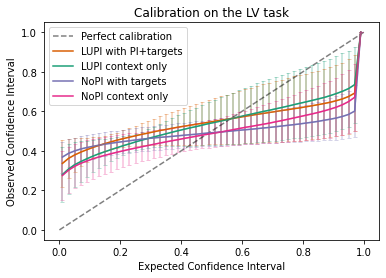

In [23]:
# lupi train #d95f02
# lupi eval #1b9e77
# nopi train #7570b3
# nopi eval #e7298a

f = plt.figure()

# add perfect line
plt.plot([0,1],[0,1], c='black', ls='--', alpha=0.5, label='Perfect calibration')

midpoints = (lupi_tr_b[:-1]+lupi_tr_b[1:])/2

plt.plot(midpoints, lupi_train_cum_mean, c='#d95f02', label='LUPI with PI+targets')
plt.plot(midpoints, lupi_eval_cum_mean, c='#1b9e77', label='LUPI context only')
plt.plot(midpoints, nopi_train_cum_mean, c='#7570b3', label = 'NoPI with targets')
plt.plot(midpoints, nopi_eval_cum_mean, c='#e7298a', label= 'NoPI context only')

plt.errorbar(midpoints, lupi_train_cum_mean, yerr=lupi_train_cum_std, c='#d95f02', alpha=0.3, capsize=2.)
plt.errorbar(midpoints, lupi_eval_cum_mean, yerr=lupi_eval_cum_std, c='#1b9e77', alpha=0.3, capsize=2.)
plt.errorbar(midpoints, nopi_train_cum_mean, yerr=nopi_train_cum_std, c='#7570b3', alpha=0.3, capsize=2.)
plt.errorbar(midpoints, nopi_eval_cum_mean, yerr=nopi_eval_cum_std, c='#e7298a', alpha=0.3, capsize=2.)

plt.legend()

plt.title('Calibration on the LV task')
plt.xlabel('Expected Confidence Interval')
plt.ylabel('Observed Confidence Interval')

f.savefig('./figures/'+time_save.strftime("%Y-%m-%d-%H%M")+'lv_calibration_caps.pdf', bbox_inches='tight')
plt.show()

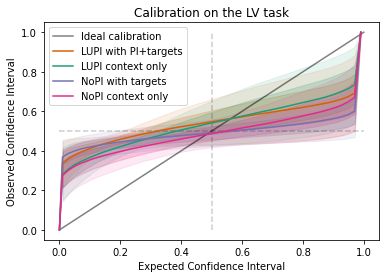

In [24]:
# lupi train #d95f02
# lupi eval #1b9e77
# nopi train #7570b3
# nopi eval #e7298a

f = plt.figure()

# add perfect line
plt.plot([0,1],[0.5,0.5], c='black', ls='--', alpha=0.2)
plt.plot([0.5,0.5],[0,1], c='black', ls='--', alpha=0.2)
plt.plot([0,1],[0,1], c='black', alpha=0.5, label='Ideal calibration')

midpoints = ((lupi_tr_b[:-1]+lupi_tr_b[1:])/2)

plt.plot([0,*midpoints], [0,*lupi_train_cum_mean], c='#d95f02', label='LUPI with PI+targets')
plt.plot([0,*midpoints], [0,*lupi_eval_cum_mean], c='#1b9e77', label='LUPI context only')
plt.plot([0,*midpoints], [0,*nopi_train_cum_mean], c='#7570b3', label = 'NoPI with targets')
plt.plot([0,*midpoints], [0,*nopi_eval_cum_mean], c='#e7298a', label= 'NoPI context only')

plt.fill_between(midpoints,
                 lupi_train_cum_mean+0.5*lupi_train_cum_std,
                 lupi_train_cum_mean-0.5*lupi_train_cum_std,
                 color='#d95f02', alpha=0.2)
plt.fill_between(midpoints,
                 lupi_eval_cum_mean+0.5*lupi_eval_cum_std,
                 lupi_eval_cum_mean-0.5*lupi_eval_cum_std,
                 color='#1b9e77', alpha=0.2)
plt.fill_between(midpoints,
                 nopi_train_cum_mean+0.5*nopi_train_cum_std,
                 nopi_train_cum_mean-0.5*nopi_train_cum_std,
                 color='#7570b3', alpha=0.2)
plt.fill_between(midpoints,
                 nopi_eval_cum_mean+0.5*nopi_eval_cum_std,
                 nopi_eval_cum_mean-0.5*nopi_eval_cum_std,
                 color='#e7298a', alpha=0.2)

plt.fill_between(midpoints,
                 lupi_train_cum_mean+1*lupi_train_cum_std,
                 lupi_train_cum_mean-1*lupi_train_cum_std,
                 color='#d95f02', alpha=0.1)
plt.fill_between(midpoints,
                 lupi_eval_cum_mean+1*lupi_eval_cum_std,
                 lupi_eval_cum_mean-1*lupi_eval_cum_std,
                 color='#1b9e77', alpha=0.1)
plt.fill_between(midpoints,
                 nopi_train_cum_mean+1*nopi_train_cum_std,
                 nopi_train_cum_mean-1*nopi_train_cum_std,
                 color='#7570b3', alpha=0.1)
plt.fill_between(midpoints,
                 nopi_eval_cum_mean+1*nopi_eval_cum_std,
                 nopi_eval_cum_mean-1*nopi_eval_cum_std,
                 color='#e7298a', alpha=0.1)

plt.legend()

plt.title('Calibration on the LV task')
plt.xlabel('Expected Confidence Interval')
plt.ylabel('Observed Confidence Interval')

f.savefig('./figures/'+time_save.strftime("%Y-%m-%d-%H%M")+'lv_calibration_shaded.pdf', bbox_inches='tight')
plt.show()

###  Example plot

In [25]:
it = iter(eval_loader)

In [26]:
z_samples = 32

with torch.no_grad():
    # get example
    pi, x, times = next(it)

    context_range = range(5,10)
    target_range = range(15,51)

    context_size = random.sample(context_range,1)[0] # some number in the range 5 to 9
    target_size = random.sample(target_range,1)[0] # some number in the range 15 to 50
    target_idx = list(range(evaluation_config['simulator']['samples'])) # a set of indices
    context_idx = random.sample(target_idx, context_size) # a subset of the target indices
    target_idx.sort()
    context_idx.sort()
    target_idx = torch.LongTensor(target_idx)
    context_idx = torch.LongTensor(context_idx)

    for _ in range(z_samples):
        # lupi
        lupi_model.train()
        _,_,lupi_train_pr = lupi_model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
        lupi_train_preds.append(lupi_train_pr.loc.detach())
        lupi_model.eval()
        lupi_eval_pr = lupi_model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
        lupi_eval_preds.append(lupi_eval_pr.loc.detach())

        # nopi
        nopi_model.train()
        _,_,nopi_train_pr = nopi_model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
        nopi_train_preds.append(nopi_train_pr.loc.detach())
        nopi_model.eval()
        nopi_eval_pr = nopi_model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
        nopi_eval_preds.append(nopi_eval_pr.loc.detach())
    # aggregate predictions
    lupi_train_mean = torch.stack(lupi_train_preds,0).mean(0)
    lupi_train_std = torch.stack(lupi_train_preds,0).std(0)
    lupi_eval_mean = torch.stack(lupi_eval_preds,0).mean(0)
    lupi_eval_std = torch.stack(lupi_eval_preds,0).std(0)
    nopi_train_mean = torch.stack(nopi_train_preds,0).mean(0)
    nopi_train_std = torch.stack(nopi_train_preds,0).std(0)
    nopi_eval_mean = torch.stack(nopi_eval_preds,0).mean(0)
    nopi_eval_std = torch.stack(nopi_eval_preds,0).std(0)

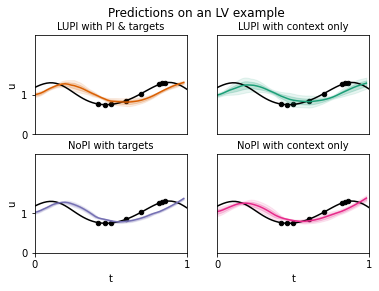

In [27]:
# lupi train #d95f02
# lupi eval #1b9e77
# nopi train #7570b3
# nopi eval #e7298a

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(times.squeeze(), x.squeeze()[:,0], c='k')
ax1.scatter(times.squeeze(0)[context_idx],x.squeeze(0)[context_idx][:,0],color='k', s=20)
ax2.plot(times.squeeze(), x.squeeze()[:,0], c='k')
ax2.scatter(times.squeeze(0)[context_idx],x.squeeze(0)[context_idx][:,0],color='k', s=20)
ax3.plot(times.squeeze(), x.squeeze()[:,0], c='k')
ax3.scatter(times.squeeze(0)[context_idx],x.squeeze(0)[context_idx][:,0],color='k', s=20)
ax4.plot(times.squeeze(), x.squeeze()[:,0], c='k')
ax4.scatter(times.squeeze(0)[context_idx],x.squeeze(0)[context_idx][:,0],color='k', s=20)

ax1.fill_between(times.squeeze()[:-1],
                 lupi_train_mean.numpy()[:,0]+lupi_train_std.numpy()[:,0], 
                 lupi_train_mean.numpy()[:,0]-lupi_train_std.numpy()[:,0],
                 color='#d95f02', alpha=0.2)
ax1.fill_between(times.squeeze()[:-1],
                 lupi_train_mean.numpy()[:,0]+2*lupi_train_std.numpy()[:,0], 
                 lupi_train_mean.numpy()[:,0]-2*lupi_train_std.numpy()[:,0],
                 color='#d95f02', alpha=0.1)

ax2.fill_between(times.squeeze()[:-1],
                 lupi_eval_mean.numpy()[:,0]+lupi_eval_std.numpy()[:,0], 
                 lupi_eval_mean.numpy()[:,0]-lupi_eval_std.numpy()[:,0],
                 color='#1b9e77', alpha=0.2)
ax2.fill_between(times.squeeze()[:-1],
                 lupi_eval_mean.numpy()[:,0]+2*lupi_eval_std.numpy()[:,0], 
                 lupi_eval_mean.numpy()[:,0]-2*lupi_eval_std.numpy()[:,0],
                 color='#1b9e77', alpha=0.1)

ax3.fill_between(times.squeeze()[:-1],
                 nopi_train_mean.numpy()[:,0]+nopi_train_std.numpy()[:,0], 
                 nopi_train_mean.numpy()[:,0]-nopi_train_std.numpy()[:,0],
                 color='#7570b3', alpha=0.2)
ax3.fill_between(times.squeeze()[:-1],
                 nopi_train_mean.numpy()[:,0]+2*nopi_train_std.numpy()[:,0], 
                 nopi_train_mean.numpy()[:,0]-2*nopi_train_std.numpy()[:,0],
                 color='#7570b3', alpha=0.1)

ax4.fill_between(times.squeeze()[:-1],
                 nopi_eval_mean.numpy()[:,0]+nopi_eval_std.numpy()[:,0], 
                 nopi_eval_mean.numpy()[:,0]-nopi_eval_std.numpy()[:,0],
                 color='#e7298a', alpha=0.2)
ax4.fill_between(times.squeeze()[:-1],
                 nopi_eval_mean.numpy()[:,0]+2*nopi_eval_std.numpy()[:,0], 
                 nopi_eval_mean.numpy()[:,0]-2*nopi_eval_std.numpy()[:,0],
                 color='#e7298a', alpha=0.1)

ax1.plot(times.squeeze()[:-1], lupi_train_mean.numpy()[:,0], c='#d95f02', label='LUPI with PI+targets')
ax2.plot(times.squeeze()[:-1], lupi_eval_mean.numpy()[:,0], c='#1b9e77', label='LUPI with context only')
ax3.plot(times.squeeze()[:-1], nopi_train_mean.numpy()[:,0], c='#7570b3', label='NoPI with targets')
ax4.plot(times.squeeze()[:-1], nopi_eval_mean.numpy()[:,0], c='#e7298a', label='NoPI with context only')

ax1.set_title('LUPI with PI & targets', fontsize=10)
ax2.set_title('LUPI with context only', fontsize=10)
ax3.set_title('NoPI with targets', fontsize=10)
ax4.set_title('NoPI with context only', fontsize=10)

ax1.set_xticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax4.set_yticks([])

ax1.set_xlim([0,1])
ax2.set_xlim([0,1])
ax3.set_xlim([0,1])
ax4.set_xlim([0,1])

ax1.set_ylim([0.,2.5])
ax2.set_ylim([0.,2.5])
ax3.set_ylim([0.,2.5])
ax4.set_ylim([0.,2.5])

ax1.set_yticks([0,1])
ax3.set_yticks([0,1])
ax3.set_xticks([0,1])
ax4.set_xticks([0,1])

ax1.set_ylabel('u')
ax3.set_ylabel('u')
ax3.set_xlabel('t')
ax4.set_xlabel('t')

# plt.fill_between(times.squeeze()[:-1],
#                  lupi_eval_mean.numpy()[:,0]-lupi_eval_std.numpy()[:,0],
#                  lupi_eval_mean.numpy()[:,0]+lupi_eval_std.numpy()[:,0], color='#1b9e77', alpha=0.2)
# plt.fill_between(times.squeeze()[:-1],
#                  lupi_eval_mean.numpy()[:,0]-2*lupi_eval_std.numpy()[:,0],
#                  lupi_eval_mean.numpy()[:,0]+2*lupi_eval_std.numpy()[:,0], color='#1b9e77', alpha=0.1)
# plt.fill_between(times.squeeze()[:-1],
#                  nopi_eval_mean.numpy()[:,0]-nopi_eval_std.numpy()[:,0],
#                  nopi_eval_mean.numpy()[:,0]+nopi_eval_std.numpy()[:,0], color='#e7298a', alpha=0.2)
# plt.fill_between(times.squeeze()[:-1],
#                  nopi_eval_mean.numpy()[:,0]-2*nopi_eval_std.numpy()[:,0],
#                  nopi_eval_mean.numpy()[:,0]+2*nopi_eval_std.numpy()[:,0], color='#e7298a', alpha=0.1)

fig.suptitle('Predictions on an LV example')

fig.savefig('./figures/'+time_save.strftime("%Y-%m-%d-%H%M")+'lv_example_predictions.pdf', bbox_inches='tight')

plt.show()